# Skin Lesion Classification

The model I will develop here will attempt to reproduce the results from the [Dermatologist-level classification of skin cancer with deep neural networks](https://www.nature.com/articles/nature21056.epdf?author_access_token=8oxIcYWf5UNrNpHsUHd2StRgN0jAjWel9jnR3ZoTv0NXpMHRAJy8Qn10ys2O4tuPakXos4UhQAFZ750CsBNMMsISFHIKinKDMKjShCpHIlYPYUHhNzkn6pSnOCt0Ftf6) published in Nature - February 2, 2017. 

## Environment Setup

The next line is to test which kernel version of Python is running.

In [38]:
!python --version

Python 3.6.7


In [39]:
!pip install -U skorch

Requirement already up-to-date: skorch in /usr/local/lib/python3.6/dist-packages (0.5.0.post0)


### Import Supporting Packages

The following cell will add additional packages requested in this notebook.

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import time
import cv2
import os
import shutil
import pandas as pd
import numpy as np
from torch import nn
from torch import optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
from collections import OrderedDict
from torchvision import datasets, transforms, models
from skorch import NeuralNetClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

## Analyze the Dataset

This is an important step in determining how the image distribution could affect the model during training. 

The HAM10000 dataset used, sourced from [Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T), is a collection of dermatoscopic images of common pigmented skin lesions. The dataset consists of 10015 images from which mode than 50% of the lesions were confirmed through pathology, and the rest was either through follow-up, expert consensus, or confirmation by in-vivo confocal microscopy.



Images are distributed through two zip files `HAM10000_images_part1.zip` and `HAM10000_images_part2.zip` and extracted into folders of the same name. These images will be sorted into `training` and `test`folders. THe images will also be furhter sorted and stored into folders representing the lesion classification for the image.

### Mount the Google Drive Directory

In [41]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Image Metadata

The file containing the lesion labels, image names, and other metadata are located in `HAM10000_metadata.csv`. We will use Pandas to read in this data for analysis and any additional processing.


#### Initial Look at the Data

Let's get a sense of the size, metadata, and distribution of the images.

In [42]:
# Read in the csv file
image_csv = pd.read_csv('/content/gdrive/My Drive/melanocytic/HAM10000_metadata.csv')

# Take a look at the first 10 rows
print(f'Size of the image dataset: {image_csv.size}')
image_csv[:10]

Size of the image dataset: 70105


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


The first two rows indicate the existence of duplicates - the __lesion_id__ is the same. Let's see what other interesting things we may be dealing with in this dataset.

In [43]:
# Get the counts of the data in each column
image_csv.count()

lesion_id       10015
image_id        10015
dx              10015
dx_type         10015
age              9958
sex             10015
localization    10015
dtype: int64

As expected, the counts for most fields are 10015, which matches the number of images we should have. As the counts show, there are some inages that do not have an indication of the age of the patiemt. Since we are only interested in image classification, age data will not be used at this time and the mising values should not pose a problem.

#### Composition of Image Classes

Next we will take a look at the balance of data to see how evenly image counts are distributed across the image classes.

In [44]:
# Get the counts of images for each classification

# Group and count
counts = image_csv.groupby('dx').count() 

# Add a summation row at the bottom of the table
tmp_cts = counts.copy()
tmp_cts.loc['sum'] = tmp_cts.sum() 

tmp_cts

,lesion_id,image_id,dx_type,age,sex,localization
dx,,,,,,
akiec,327,327,327,327,327,327
bcc,514,514,514,514,514,514
bkl,1099,1099,1099,1089,1099,1099
df,115,115,115,115,115,115
mel,1113,1113,1113,1111,1113,1113
nv,6705,6705,6705,6660,6705,6705
vasc,142,142,142,142,142,142
sum,10015,10015,10015,9958,10015,10015


In [0]:
# Graph the counts
def show_counts(df):
  df.plot.bar(legend=False, fontsize=15, rot=30);
  plt.title("Image Distribution")
  plt.ylabel("Image Count")
  plt.xlabel("Class Names")
  plt.show()

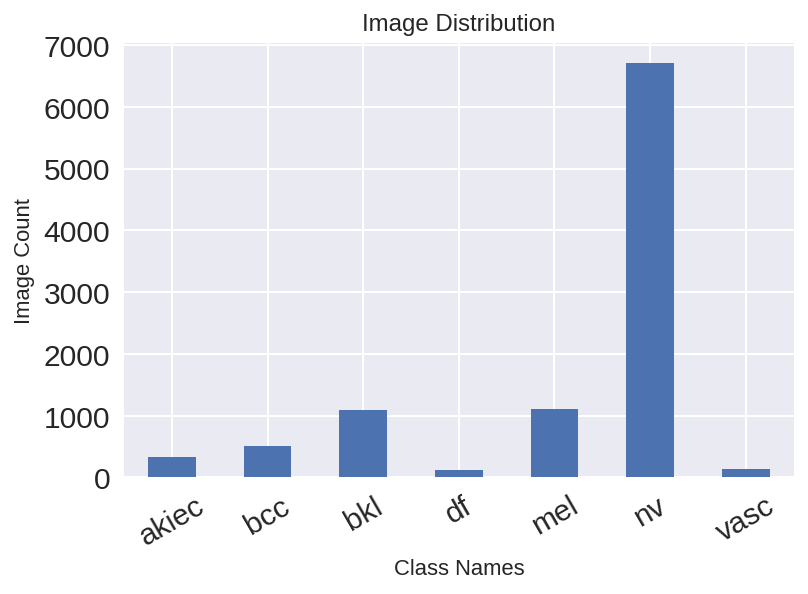

In [46]:
show_counts(counts[['image_id']])

The spread between the label with the lowest count and that of the highest count is __6,590__

In [47]:
counts.lesion_id.max() - counts.lesion_id.min()

6590

### Balancing the Data

So when all you have is a phaser, everything will look like a Klingon. I believe it's the same for image classification. If we train our model with a bunch of benign neoplasms of melanocytes, everything will look like Melanocytic Nevi (nv). 

This data is definitely imbalanced and will need to be dealt with.

#### Assessing the impact of Duplicates

The first table, under the [Initial Look at the Data](#Initial Look at the Data) section, indicates there are multiple images of the same lesion - same `lesion_id` entries with different `image_id`.

There are a few approaches I'm thiking about in relation to dealing with duplicate images as well as the over abundant set of Melanocytic Nevi images. 

**One Thought**

There are 2,290 duplicate images in the 'nv' class (see code below). I could remove all but the first of each 'nv' duplicate set fron the dataset. I could then randomly remove about 4,500 additional images from this class. This would bring the class count for 'nv' more in line with the counts of the minority classes. I would then hunt down additional images to boost the counts in the other classes.

In [48]:
# Quantify the 'nv' duplicates
  # Filter by 'dx' = 'nv' and group the 'lesion_id'
dx_grouped = image_csv[image_csv.dx == 'nv'].groupby('lesion_id')

  # Count the group that has more than one record
dx_sizes = dx_grouped.filter(lambda x: len(x) > 1)

print(f"Number of duplicates with label of 'nv': {len(dx_sizes)}")

Number of duplicates with label of 'nv': 2290


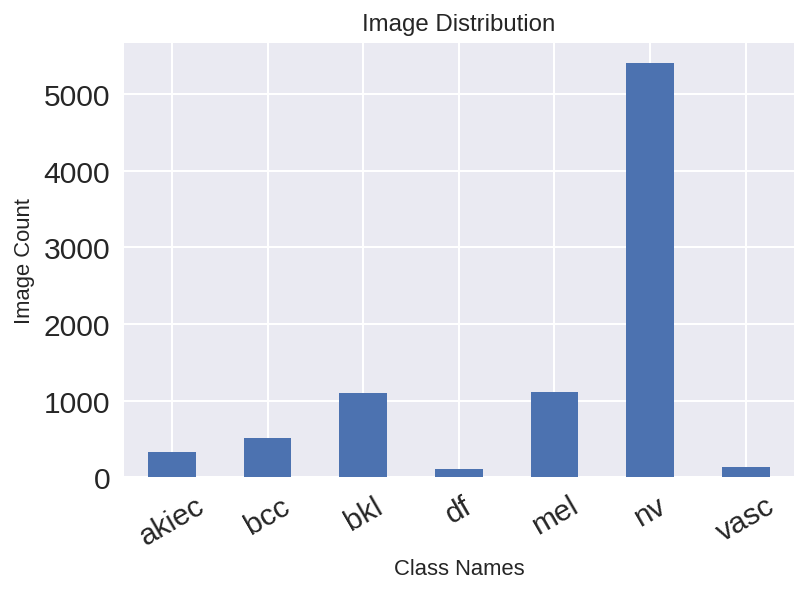

In [49]:
# Drop duplicate 'nv' images
  # Get a copy of the data
image_csv_copy = image_csv.copy()
  # get the indices of the duplictes - except for the first of each duplicate group
drop_indices = list(dx_sizes[dx_sizes.duplicated(['lesion_id'],keep='first')].index)
  # drop record based on index
image_csv_copy = image_csv_copy.drop(drop_indices)

  # Group and count again
counts = image_csv_copy.groupby('dx').count() 

  # Graph the results
show_counts(counts[['image_id']])

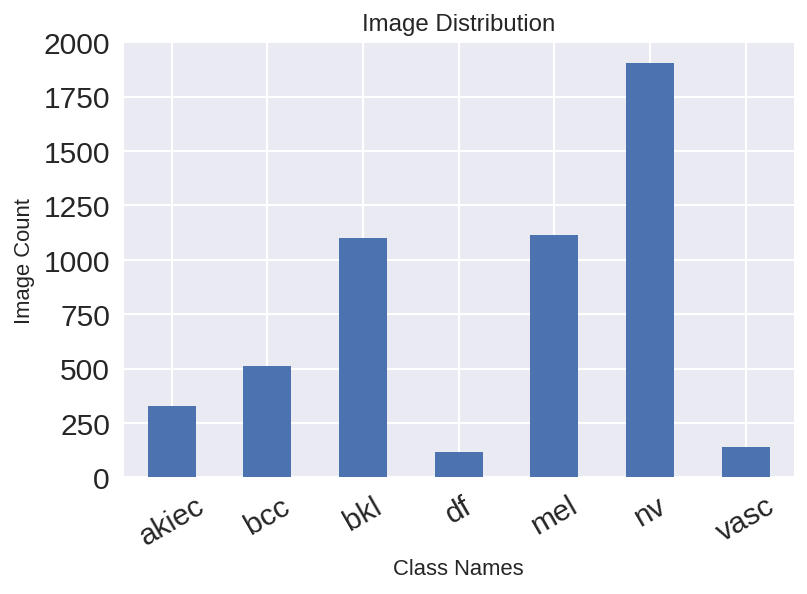

In [50]:
# Randomly drop 'nv' images
np.random.seed(10)
  # Grab all 'nv' images
tmp_nv = image_csv_copy[image_csv_copy['dx'] == 'nv']
  # rab a random set of indices
drop_indices = np.random.choice(tmp_nv.index, 3500, replace=False)
  # Drop the randomly selected records
image_csv_copy = image_csv_copy.drop(drop_indices)

  # Group and count
counts = image_csv_copy.groupby('dx').count() 

  # Graph the results
show_counts(counts[['image_id']])

**Second Thought**

Remove all but the first image in each duplicate set of the entire dataset so I can apply a consistent data augmentation across the ehtire dataset. Since the duplicates are additional images of a lesion being classified, further data augmentation would duplicate the duplicates, which is another form of data imbalance. I could then randomly remove about 5,500 'nv' images from the dataset.

I'm going for my second thought.

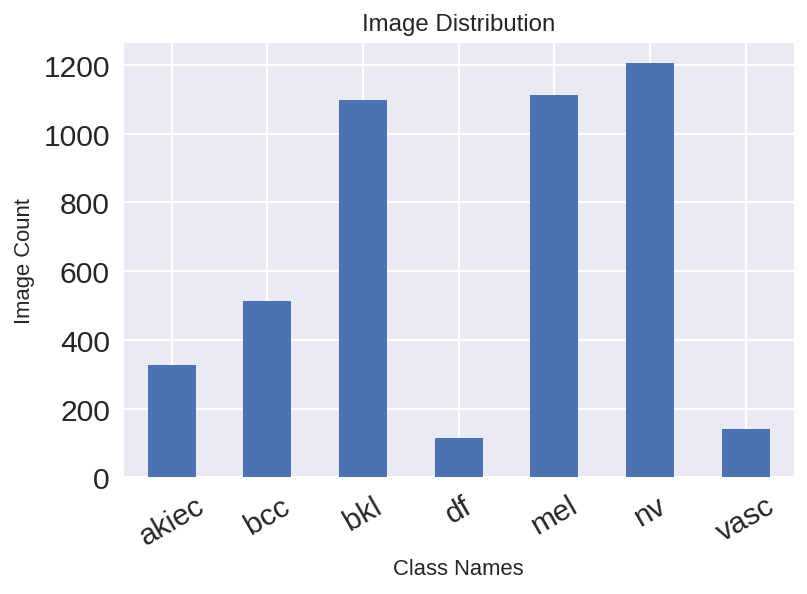

In [51]:
# Drop all duplicates
  # Make a copy of the original dataset
dropped_csv = image_csv.copy()
  # Drop all but the first of each duplicated image
dropped_csv.drop_duplicates(keep='first')
  # Grab all 'nv' images
tmp_nv = dropped_csv[dropped_csv['dx'] == 'nv']
  # rab a random set of indices
drop_indices = np.random.choice(tmp_nv.index, 5500, replace=False)
  # Drop the randomly selected records
dropped_csv = dropped_csv.drop(drop_indices)

  # Group and count
counts = dropped_csv.groupby('dx').count() 

  # Graph the results
show_counts(counts[['image_id']])

## Sort the Images

#### Extract Labels and Create Folders

The diagnosis, which will be our class labels and folder names, are in the column labeled `dx`.

In [52]:
labels = image_csv.dx.unique()

print(f'Number of labels: {len(labels)}')

print(f'The labels: {labels}')

Number of labels: 7
The labels: ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


#### Create the Directory Structure

In [0]:
# Identify the base directroy
train_dir = '/content/gdrive/My Drive/melanocytic/data/train'
test_dir = '/content/gdrive/My Drive/melanocytic/data/test'

# Create the train and test folders
if not os.path.exists(train_dir):
  os.mkdir(train_dir)
if not os.path.exists(test_dir):
  os.mkdir(test_dir)

# Create the labeled folders
for label in labels:
  #Create folders in training directory
  tmp_train_dir = os.path.join(train_dir, label)
  
  if not os.path.exists(tmp_train_dir):
    os.mkdir(tmp_train_dir)   
  
  #Create folders in test directory
  tmp_test_dir = os.path.join(test_dir, label)
  
  if not os.path.exists(tmp_test_dir):
    os.mkdir(tmp_test_dir) 

#### Split Training & Test

In [0]:
df_train, df_test = train_test_split(dropped_csv, test_size=0.2, random_state=101, stratify=dropped_csv['dx'])

In [0]:
print(f'Size of the training set: {df_train.size}, which is {df_train.size/dropped_csv.size * 100}% of the dataset')
print(f'Size of the test set: {df_test.size}, which is {df_test.size/dropped_csv.size * 100}% of the dataset')

Size of the training set: 25284, which is 80.0% of the dataset
Size of the test set: 6321, which is 20.0% of the dataset


#### Move the Images

In [0]:
ham_src_path = '/content/gdrive/My Drive/melanocytic/HAM10000'

def organize_image(image_id, destination_path):
  ham_src_img_path = os.path.join(ham_src_path, f'{image_id}.jpg')
  
  if os.path.isfile(ham_src_img_path):
    shutil.move(ham_src_img_path, destination_path) 
  else:
      print(f'{image_id} not found')

In [0]:
for i, record in df_train.iterrows():
  destination_path = os.path.join(train_dir, record.dx, f'{record.image_id}.jpg')
  organize_image(record.image_id, destination_path)


In [0]:
for i, record in df_test.iterrows():
  destination_path = os.path.join(test_dir, record.dx, f'{record.image_id}.jpg')
  organize_image(record.image_id, destination_path)


## Visualize the Images

As per documentation listed on [TORCHVISION.MODELS](https://pytorch.org/docs/stable/torchvision/models.html#torchvision-models) page:

* Heignt  and Width are expected to be at least 224 
* Images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]`

In [0]:
resize=(224, 224)
data_transforms = {
    'train': transforms.Compose([transforms.Resize(resize),
                                 transforms.RandomRotation(30),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406],
                                                      [0.229, 0.224, 0.225])]),

    'test': transforms.Compose([transforms.Resize(resize),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]),
}


In [0]:
data_dir = '/content/gdrive/My Drive/melanocytic/data'
train_data = datasets.ImageFolder(data_dir + '/train', transform=data_transforms['train'])
test_data = datasets.ImageFolder(data_dir + '/test', transform=data_transforms['test'])

dataloaders = OrderedDict([
    ('train', torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)),
    ('test', torch.utils.data.DataLoader(test_data, batch_size=64))
])

In [55]:
print(f'Number of classes: {len(train_data.classes)}')
classes = train_data.classes
print(f'Classes: {classes}')
print(f'Number of inages in dataset: {len(train_data)}')

Number of classes: 7
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Number of inages in dataset: 3612


In [0]:
def imshow(image, title, normalize=True):
    image = image.numpy().transpose((1, 2, 0))
    
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    plt.title(title)
    plt.imshow(image)

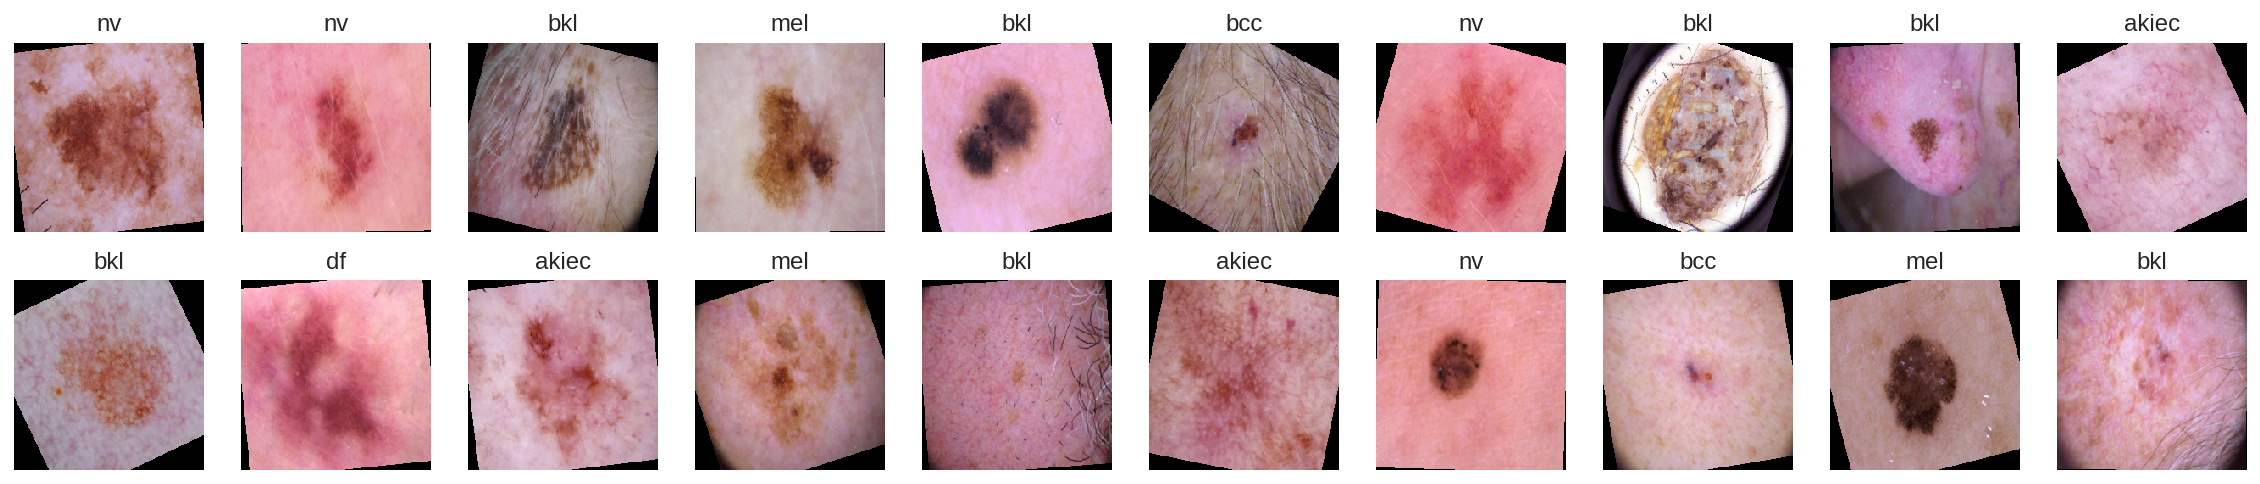

In [57]:
# plot the images in the batch, along with the corresponding labels
# change this to the trainloader or testloader 
data_iter = iter(dataloaders['train'])
images, labels = next(data_iter)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20

for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx], classes[labels[idx]])

In [58]:
model_scratch = models.inception_v3(pretrained=True)
model_scratch

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.torch/models/inception_v3_google-1a9a5a14.pth
108857766it [00:05, 20654116.48it/s]


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [60]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

# Freeze parameters to ensure we don't back propagate through these layers. 
for param in model_scratch.parameters():
    param.requires_grad = False
    
#model_scratch.fc = nn.Sequential(nn.Linear(192, 3))

model_scratch.fc = nn.Sequential(nn.Linear(2048, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 7),
                                 nn.LogSoftmax(dim=1))

criterion_scratch = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer_scratch = optim.Adam(model_scratch.fc.parameters(), lr=0.003)

# Decay LR by a factor of 0.1 every 7 epochs
lr_scheduler_scratch = lr_scheduler.StepLR(optimizer_scratch, step_size=7, gamma=0.1)

if use_cuda:
    model_scratch.cuda();
    
model_scratch

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [0]:
#epochs = 1
#steps = 0
#running_loss = 0
#print_every = 5

def train(n_epochs, loaders, model, optimizer, scheduler, criterion, use_cuda, save_path):

    for epoch in range(n_epochs):

        train_loss = 0.0
        valid_loss = 0.0
        scheduler.step()
        ###################
        # train the model #
        ###################
        model.train() # set the model to training mode

        for batch_idx, (inputs, labels) in enumerate(loaders['train']):

            # Move input and label tensors to the default device
            if use_cuda:
                inputs, labels = inputs.cuda(), labels.cuda()

            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            logps = model.forward(inputs)
            # calculate the batch loss
            loss = criterion(logps, labels)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()

            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (inputs, labels) in enumerate(loaders['valid']):

            # Move input and label tensors to the default device
            if use_cuda:
                inputs, labels = inputs.cuda(), labels.cuda()

            # forward pass: compute predicted outputs by passing inputs to the model
            logps = model.forward(inputs)
            # calculate the batch loss
            batch_loss = criterion(logps, labels)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)

        # calculate average losses
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss 
            
    # return trained model
    return model

In [0]:
model_scratch = train(1, dataloaders, model_scratch, optimizer_scratch, lr_scheduler_scratch,
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

RuntimeError: std::exception